In [42]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

FUTURE_MONTH_MAP = {
    'F': 1, 'G': 2, 'H': 3, 'J': 4, 'K': 5, 'M': 6,
    'N': 7, 'Q': 8, 'U': 9, 'V': 10, 'X': 11, 'Z': 12
}

In [43]:
df = pd.read_csv('Data/gold_futures_ohlcv.csv', parse_dates=['ts_event'])
df["ts_event"] = pd.to_datetime(df["ts_event"]).dt.tz_convert('America/Chicago') # ensure it's UTC
df = df.set_index('ts_event', inplace=False)

In [44]:
def _get_contract_year(row):
    contract_year_first_digit = int(row["symbol"][3])
    curr_year = row.name.year
    if contract_year_first_digit < curr_year % 10:
        contract_year = math.ceil(curr_year / 10) * 10 + contract_year_first_digit
    else:
        contract_year = math.floor(curr_year / 10) * 10 + contract_year_first_digit
    return contract_year

In [45]:
def _get_expiry_length(row):
    month = FUTURE_MONTH_MAP[row['symbol'][2]]
    year = row["contract_year"]
    # Calculate the difference in months
    return (year - row.name.year) * 12 + month - row.name.month


In [46]:
def _get_near_roll_date(row, DAYS_BEFORE_EXPIRY):
    year = row["contract_year"]
    month = row["contract_month"]
    # Get all business days in the contract month
    # Using a fixed day like 28 to be safe for all months
    global cache
    if f"{year}-{month:02d}-01" in cache:
        bdays = cache[f"{year}-{month:02d}-01"]
    else:
        start_of_month = pd.to_datetime(f"{year}-{month:02d}-01").tz_localize('America/Chicago')
        end_of_month = start_of_month + pd.offsets.MonthEnd(0)
        bdays = pd.bdate_range(start=start_of_month, end=end_of_month)
        cache[f"{year}-{month:02d}-01"] = bdays
    # The roll date is 3 days before the 3rd to last business day
    roll_date = bdays[-3] - pd.DateOffset(days=DAYS_BEFORE_EXPIRY)
    if roll_date.weekday() == 5: # If it's a Saturday or Sunday
        roll_date = roll_date - pd.Timedelta(days=1)
    return roll_date


In [47]:
DAYS_BEFORE_EXPIRY = 3

In [48]:
single_contract_filter = (df["symbol"].str.len() == 4)
fdf = df[single_contract_filter].copy()

# adding necessary data
fdf["contract_year"] = fdf.apply(_get_contract_year, axis=1)
fdf["contract_month"] = fdf.apply(lambda row: FUTURE_MONTH_MAP[row['symbol'][2]], axis=1)
fdf["expiry_length"] = fdf.apply(_get_expiry_length, axis=1)

In [49]:
import pandas as pd
from functools import lru_cache

# This helper function will be cached automatically
# The cache stores the results of calls with unique (year, month) pairs.
@lru_cache(maxsize=None)
def _get_business_days_for_month(year, month):
    """
    Calculates and returns all business days for a given month.
    Results are cached to avoid re-calculating for the same month.
    """
    start_of_month = pd.to_datetime(f"{year}-{month:02d}-01").tz_localize('America/Chicago')
    end_of_month = start_of_month + pd.offsets.MonthEnd(0)
    return pd.bdate_range(start=start_of_month, end=end_of_month)


def _get_near_roll_date(row, DAYS_BEFORE_EXPIRY):
    year = row["contract_year"]
    month = row["contract_month"]
    
    # Call the cached helper function to get the business days
    bdays = _get_business_days_for_month(year, month)
    
    # The roll date is 3 days before the 3rd to last business day
    roll_date = bdays[-3] - pd.DateOffset(days=DAYS_BEFORE_EXPIRY)
    
    # Correctly check if the roll_date is a Saturday (5) or Sunday (6)
    if roll_date.weekday() >= 5: 
        roll_date = roll_date - pd.Timedelta(days=1) # Move to Friday
        
    return roll_date

fdf['contract_roll_date'] = fdf.apply(lambda row: _get_near_roll_date(row, DAYS_BEFORE_EXPIRY=3), axis=1)

In [50]:
fdf[fdf['expiry_length'] == 0].head(10)  

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,contract_year,contract_month,expiry_length,contract_roll_date
ts_event,,,,,,,,,,,,,
2010-06-05 19:00:00-05:00,35,1,197009,1220.4,1220.7,1220.4,1220.7,2,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-06 19:00:00-05:00,35,1,197009,1215.1,1244.7,1211.0,1241.6,860,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-07 19:00:00-05:00,35,1,197009,1238.7,1252.1,1234.1,1237.0,761,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-08 19:00:00-05:00,35,1,197009,1238.2,1238.2,1222.0,1231.6,419,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-09 19:00:00-05:00,35,1,197009,1230.8,1230.8,1215.1,1217.1,478,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-10 19:00:00-05:00,35,1,197009,1219.5,1229.6,1218.0,1227.0,179,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-12 19:00:00-05:00,35,1,197009,1230.2,1230.2,1230.2,1230.2,1,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-13 19:00:00-05:00,35,1,197009,1232.0,1232.7,1217.7,1222.3,229,GCM0,2010,6,0,2010-06-25 00:00:00-05:00
2010-06-14 19:00:00-05:00,35,1,197009,1224.0,1236.0,1222.4,1233.5,242,GCM0,2010,6,0,2010-06-25 00:00:00-05:00


In [51]:
# split into front month and second month
frdf = fdf[fdf["expiry_length"] == 0].copy()
sdf = fdf[fdf["expiry_length"] == 1].copy()

In [52]:
adj_frdf = frdf[frdf.index.date < frdf['contract_roll_date'].dt.date].copy()

# need to align because second month df doesn't have first month expiration date info
common_idx = frdf.index.intersection(sdf.index)
sdf.loc[common_idx, 'fm_roll_date'] = frdf.loc[common_idx, 'contract_roll_date'].copy()
adj_sdf = sdf[sdf.index.date >= sdf['fm_roll_date'].dt.date].copy()

In [53]:
# combine adjusted dataframes
ndf = pd.concat([adj_frdf, adj_sdf], axis=0).sort_index()

In [54]:
is_roll_day = ndf['symbol'] != ndf['symbol'].shift(-1)

In [55]:
ndf.loc[is_roll_day, 'spread'] = ndf['open'].shift(-1) - ndf['close']
ndf['spread'] = ndf['spread'].fillna(0)

In [56]:
ndf['spread'].describe()

count    3529.000000
mean        0.130887
std         2.373668
min       -40.400000
25%         0.000000
50%         0.000000
75%         0.000000
max        51.900000
Name: spread, dtype: float64

In [58]:
# compute adjustments
adjustment = ndf['spread'].iloc[::-1].cumsum().iloc[::-1]
cols_to_adjust = ['open', 'high', 'low', 'close']
ndf[cols_to_adjust] = ndf[cols_to_adjust].add(adjustment, axis=0)

In [59]:
ndf.tail(30)

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,contract_year,contract_month,expiry_length,contract_roll_date,fm_roll_date,spread
ts_event,,,,,,,,,,,,,,,
2025-06-14 19:00:00-05:00,35,1,287,3425.2,3425.2,3425.2,3425.2,1,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,0.0
2025-06-15 19:00:00-05:00,35,1,287,3421.4,3421.4,3368.6,3368.6,32,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,0.0
2025-06-16 19:00:00-05:00,35,1,287,3381.5,3381.5,3359.3,3371.7,18,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,0.0
2025-06-17 19:00:00-05:00,35,1,287,3368.5,3375.1,3348.3,3348.3,38,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,0.0
2025-06-18 19:00:00-05:00,35,1,287,3333.2,3356.1,3333.2,3347.9,16,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,0.0
2025-06-19 19:00:00-05:00,35,1,287,3350.1,3356.0,3324.2,3346.4,84,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,0.0
2025-06-22 19:00:00-05:00,35,1,287,3349.1,3371.1,3333.2,3341.2,19,GCM5,2025,6,0,2025-06-23 00:00:00-05:00,NaT,-21.7
2025-06-23 19:00:00-05:00,35,1,42020775,3341.2,3360.1,3301.3,3329.5,1219,GCN5,2025,7,1,2025-07-25 00:00:00-05:00,2025-06-23 00:00:00-05:00,0.0
2025-06-24 19:00:00-05:00,35,1,42020775,3332.9,3344.4,3316.9,3344.4,505,GCN5,2025,7,1,2025-07-25 00:00:00-05:00,2025-06-23 00:00:00-05:00,0.0


<Axes: xlabel='ts_event'>

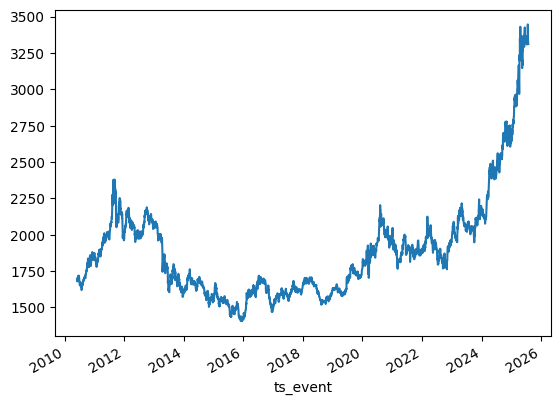

In [60]:
ndf['close'].plot()